In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import curve_fit
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy import optimize
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
%matplotlib inline

In [2]:
# 2spot3 location 119,55 is the nice one

In [7]:
cd /Users/austinmcdonald/Desktop/test/cut/Ba/2Spot7/

/Users/austinmcdonald/Desktop/test/cut/Ba/2Spot7


In [8]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [10]:
eCoeff = 0.01160
eOffset= 1917
z=0
w=1
BSend = len(files)
Shape = 221
xvs = np.arange(0,Shape)
neighborhood_size = 9
Row = int(4) # define the area to take around the spots
Col = int(4) # define the area to take around the spots

DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
Datatot = DataSub
fitts = []

AllPairs =[]
SpotInfo2 = []

ImageB = []
        

MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
for x in range(BSend-50,BSend):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM)
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 2) # fits 2nd order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/50


for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    DataSub += Images


data = DataSub

threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 


Images = None
ImageB = None
data   = None
Slices = None
labeled= None
num_objects=None

############################################################## 
Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<(Shape-10) and YY>10 and YY<(Shape-10):
        Xc.append(XX)
        Yc.append(YY)

for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    Images[Images < 0] = 0 

    SpotInfoHolder = []

    for we in range(0,len(Xc)):
        Xindex = int(Xc[we])
        Yindex = int(Yc[we])

        spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot = spot1[2:7,2:7]
        SpotRemove = np.zeros(5**2).reshape((5,5))
        spot2[2:7,2:7]=SpotRemove
        spotB = spot2

        ATot = spot.sum()
        ATotB = spot2.sum()
        SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

########################################################################################  

    clear_output()
    print('Finding all areas in dataset'+' '+str(z)) 
    print('Finding all areas in folder'+' '+str(w)) 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

Par = len(AllPairs)
AVG = 5
Mnumb = 5
Tau = []
Signal = []
BackG  = []
SignalF = []
BackGF  = []
sigmas =  []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,4]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
    vals =np.arange(0,len(aa))
    
    sigmas.append(np.sqrt(np.array(aa)))
    
    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit*(25/56))
    bac = np.array(aaB-ffit)

    SigF = np.array(HoldArea)
    bacF = np.array(HoldAreaB)
    
    meanI = np.mean(Sig[:Mnumb])
    sigmaI = np.std(Sig[:Mnumb])
    meanE = np.mean(Sig[-Mnumb:])
    sigmaE = np.std(Sig[-Mnumb:])
    meanM = np.mean(Sig)
    T = len(Sig)
    tau = ((meanM - meanE)/(meanI -meanE))*T

    Tau.append(tau)
    Signal.append(Sig)
    BackG.append(bac)
    SignalF.append(SigF)
    BackGF.append(bacF)
    

    
Tau2 = []
Offset = 5
for x in range(0,Par):
    TauH = Tau[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau2.append(TauH) 
    
Tau3 = []
Offset = 3
for x in range(0,Par):
    TauH = Tau2[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau3.append(TauH)


#data = []
#PairsMade = []
chiSQUAR = []
chiLINE = []
#chiFIT=[]
chiRa = []
meanDif = []
#Dtau = []
areaS=[]
areaSS=[]
areaPre=[]
areaPost=[]
ITEN=[]
MeanI=[]
MeanE=[]
chiDiff = []
Offset =3
NUMBER = 0
errors=[]
for x in range(0,Par):
    TauH   = Tau3[x]
    Data   = Signal[x] 
    DataLeft  = Data[:int(TauH)-Offset]
    DataRight = Data[int(TauH)+Offset:]
    sigmasLeft  = sigmas[x][:int(TauH)-Offset]
    sigmasRight = sigmas[x][int(TauH)+Offset:]
    mean  = np.mean(Data)
    meanI  = np.mean(DataLeft)
    meanE  = np.mean(DataRight)


    chiHIGH = np.sum((DataLeft - meanI)**2/abs(sigmasLeft)**2)/749
    chiLOW = np.sum((DataRight - meanE)**2/abs(sigmasRight)**2)/749

    val = np.arange(0,len(Data),1)
    coefs=np.polyfit(val,Data,1)    
    ffit  = coefs[0]*val+coefs[1]
    chiFit  = np.sum((ffit - Data)**2/abs(sigmas[x])**2)/748


    chiRa.append((chiLOW+chiHIGH)/ chiFit)
    meanDif.append(meanI-meanE)
    areaS.append(ffit)
    areaSS.append(Data)
    areaPre.append(DataLeft)
    areaPost.append(DataRight)
    MeanI.append(meanI)
    MeanE.append(meanE)
    errors.append(sigmas[x])
    chiDiff.append((chiLOW+chiHIGH) - chiFit)
    chiSQUAR.append(chiLOW+chiHIGH)
    chiLINE.append(chiFit)
    

print("done!")

n=0
for x in range(0,len(meanDif)):
    if meanDif[x]>70 and chiDiff[x]<-0.75:
        n+=1
print(n)

Finding all areas in dataset 0
Finding all areas in folder 1
On file 750 of 750


//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done!
15


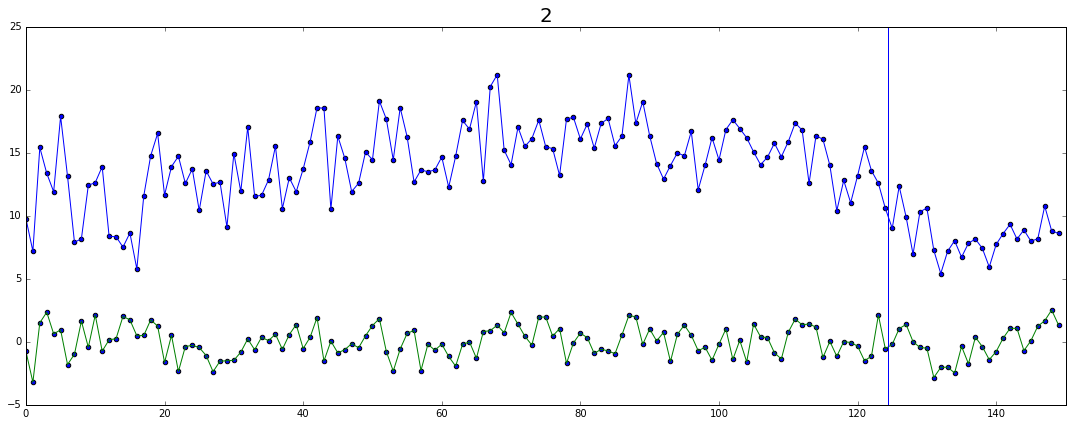

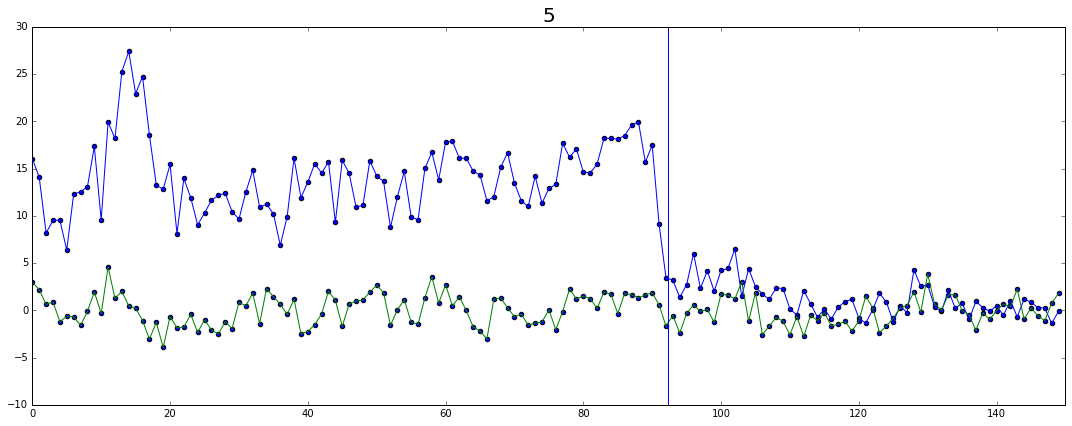

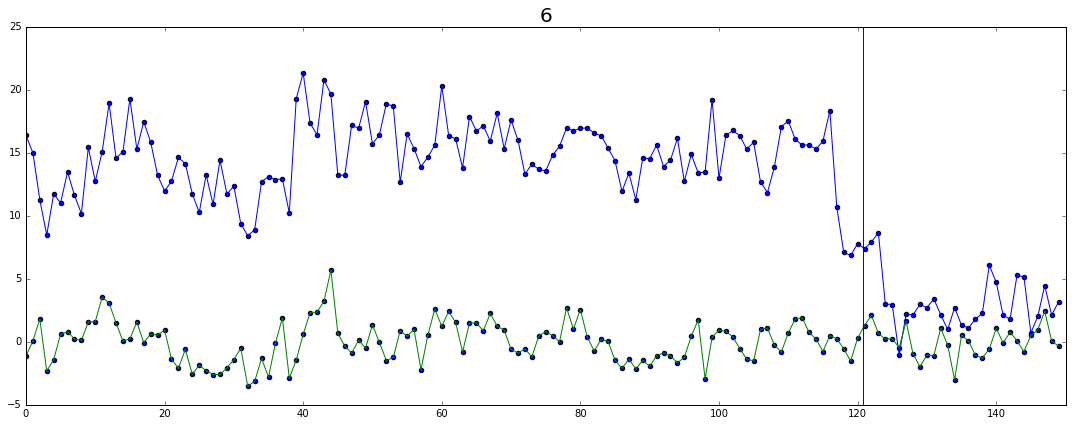

In [326]:
sign = Signal #
backs = BackG #
vals =np.arange(0,len(sign[0]))
#valsf =np.arange(0,len(AREA[0][0]))
Q=0
Offset=4
for x in range(0,len(sign)):
    if meanDif[x]>70 and chiDiff[x]<-0.75:
    #if True :
        plt.figure(figsize=(15,6))
        plt.title(x,fontsize=20)

        plt.plot(vals,sign[x]/25)
        plt.scatter(vals,sign[x]/25)
        
        plt.plot(vals,backs[x]/56)
        plt.scatter(vals,backs[x]/56)
        plt.axvline(Tau3[x])
        plt.xlim(0,150)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()

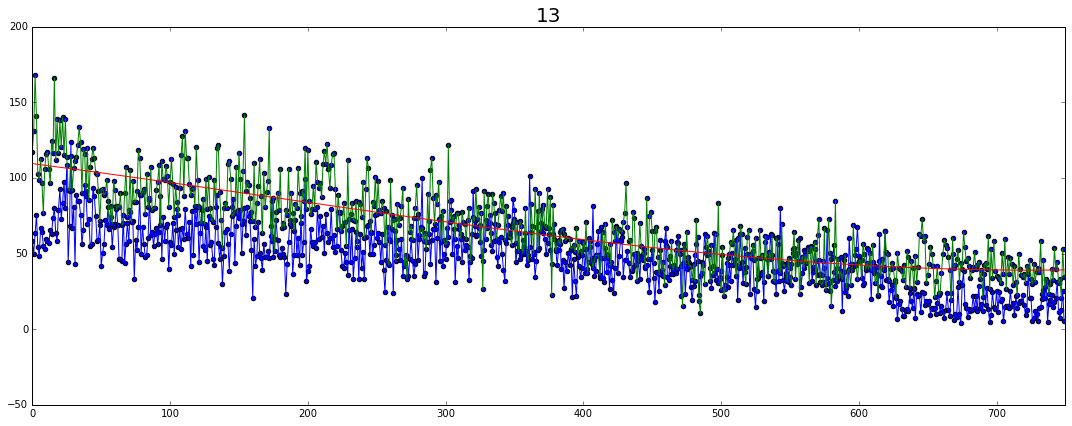

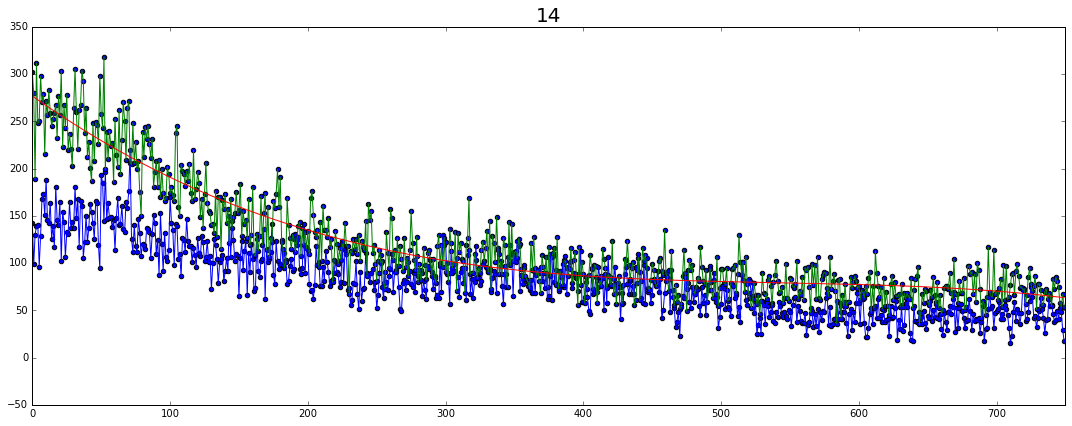

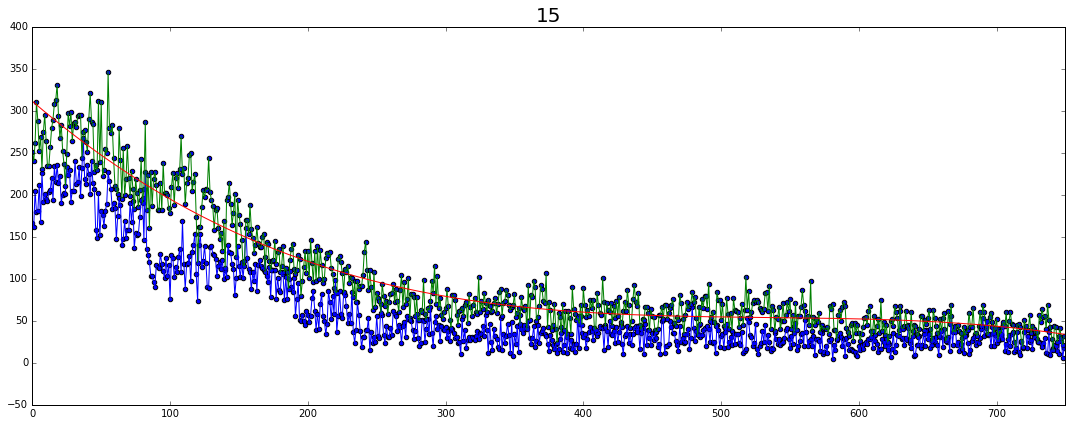

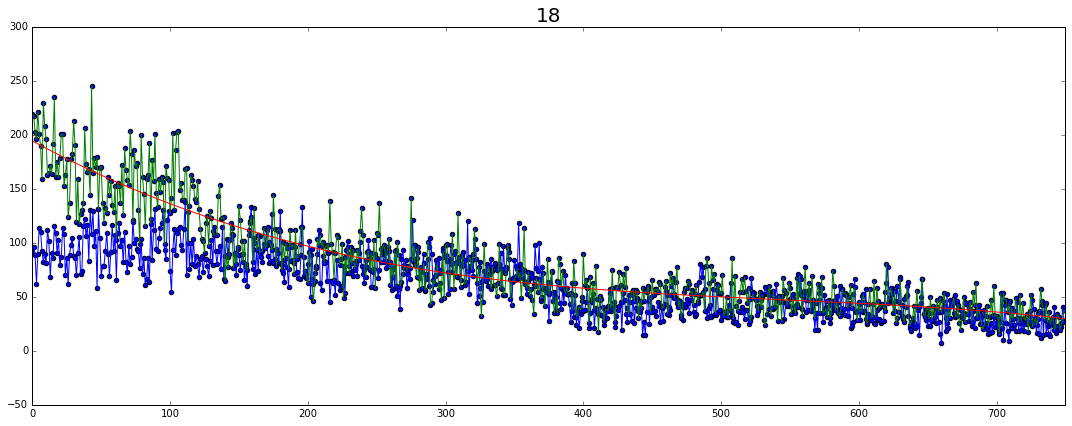

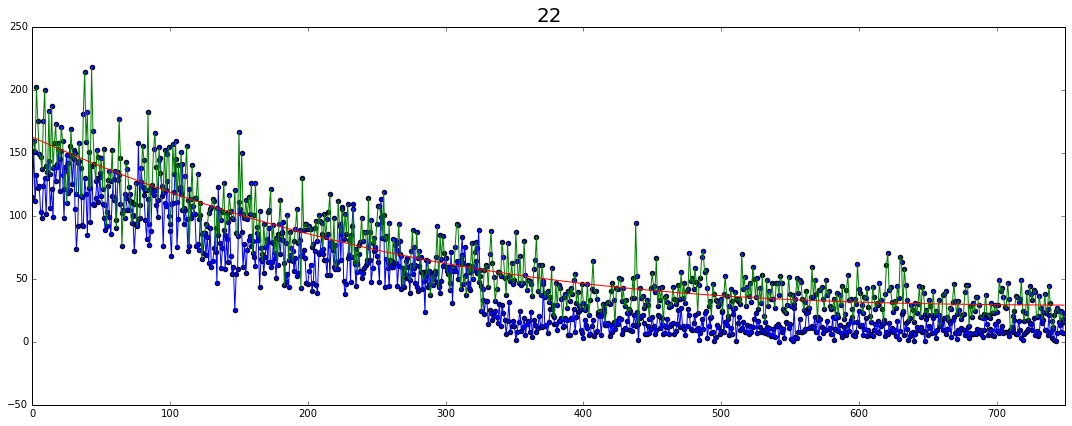

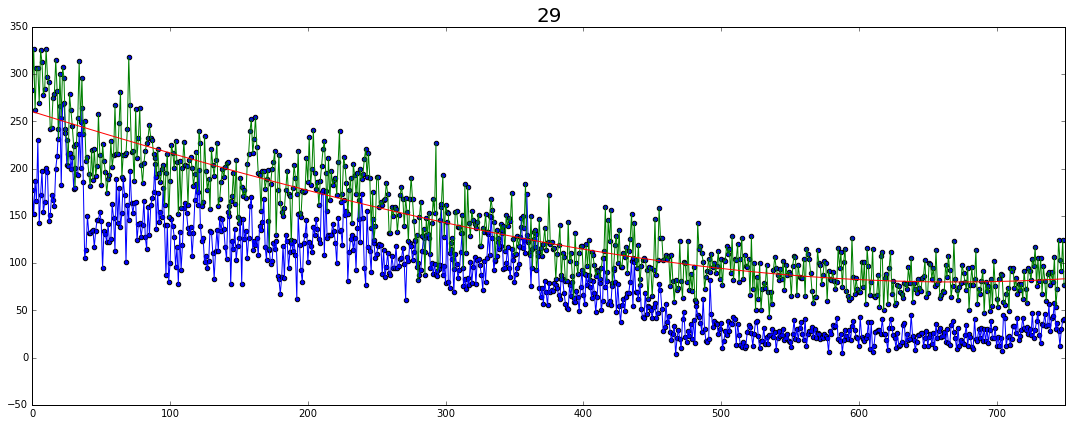

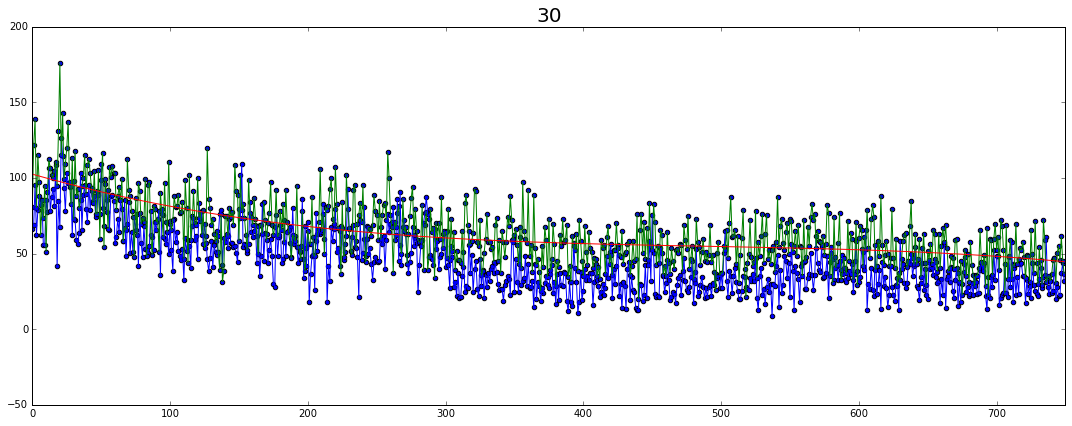

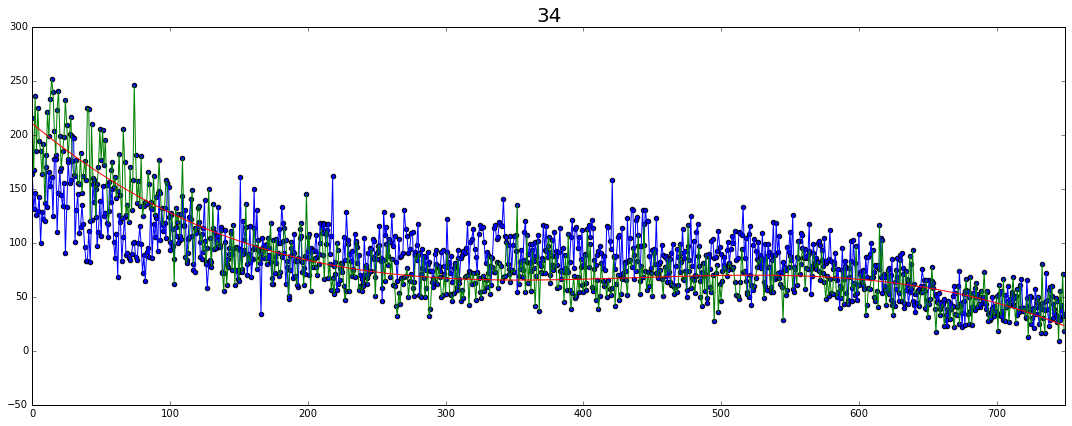

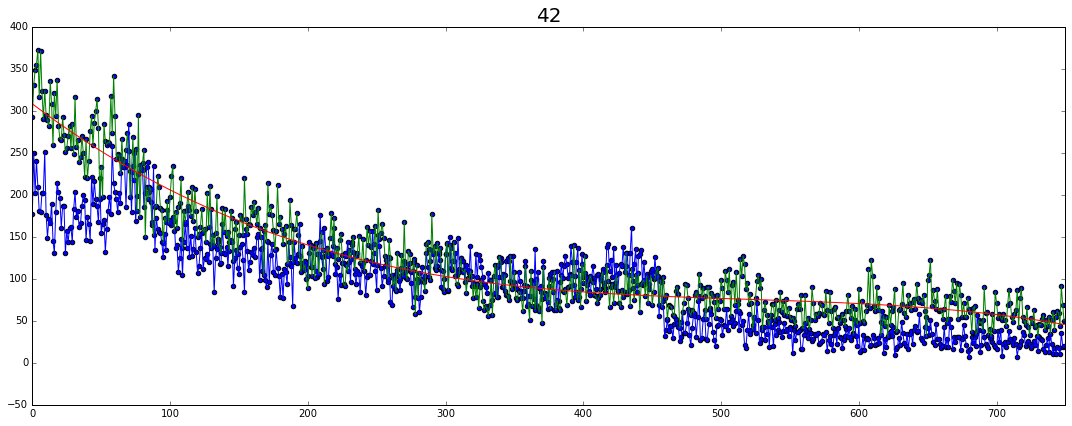

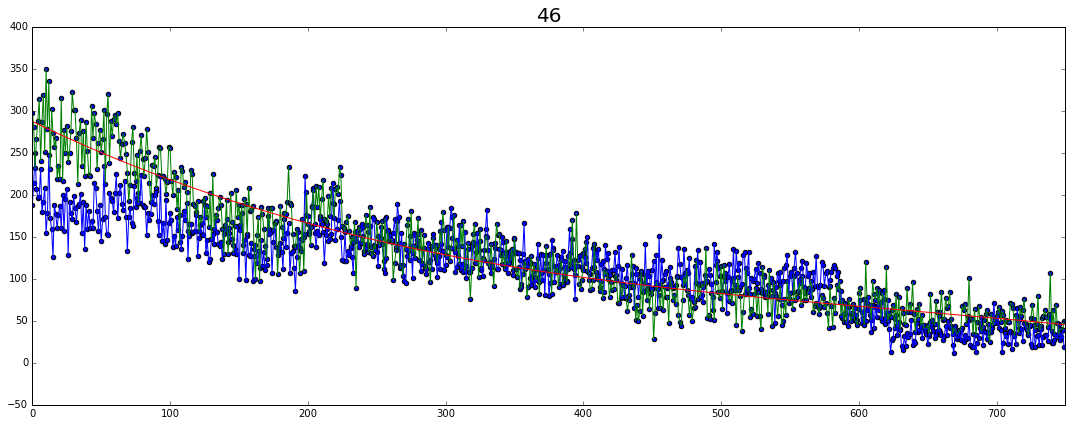

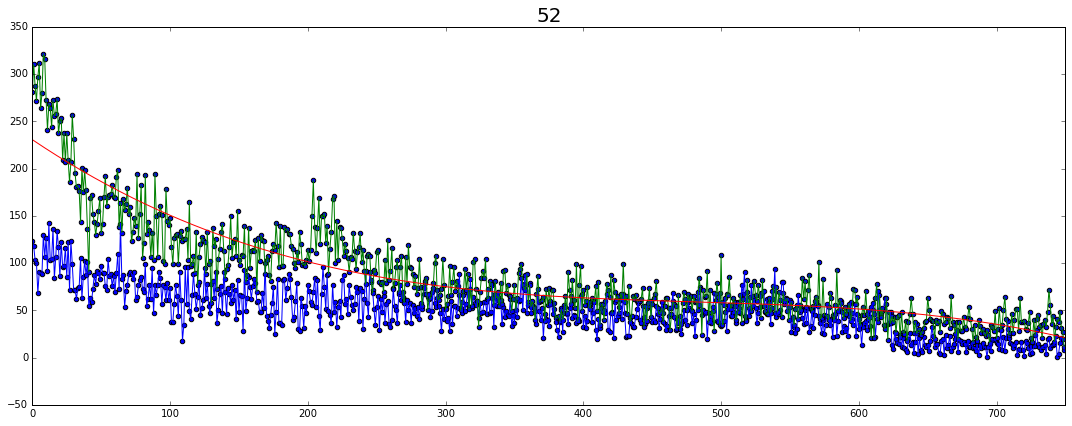

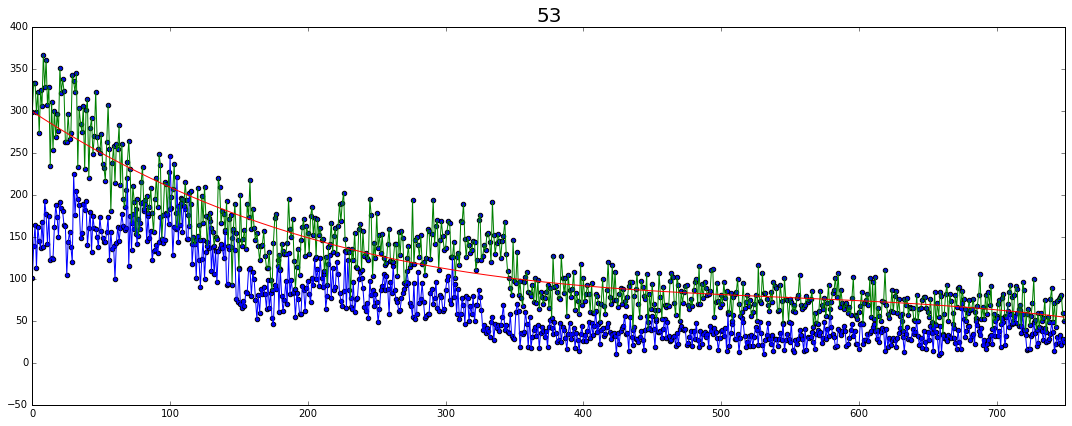

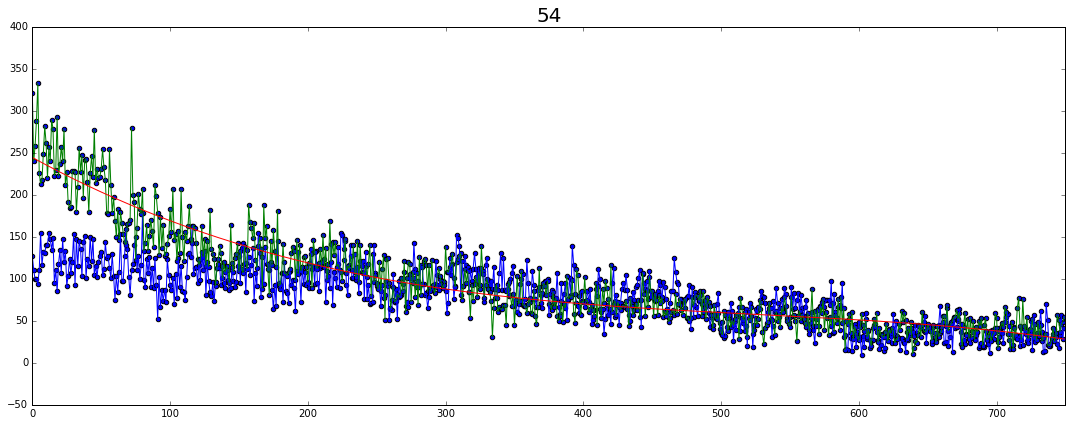

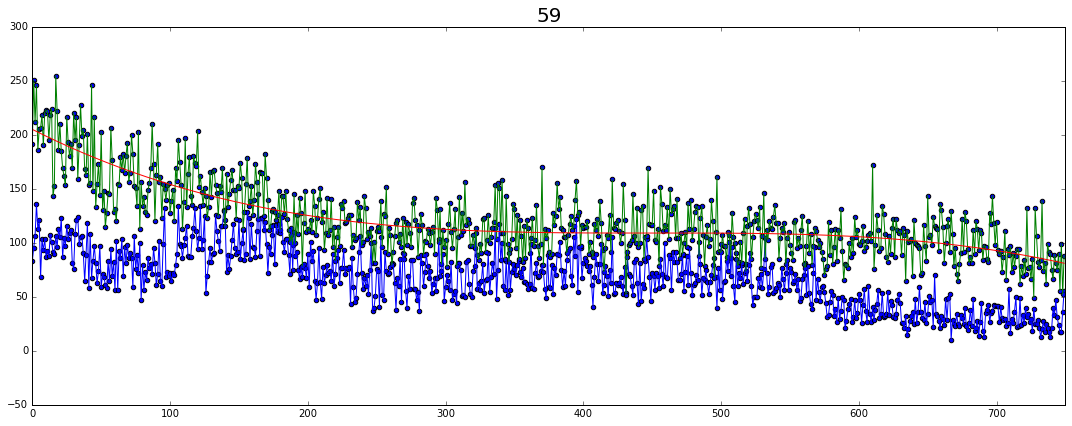

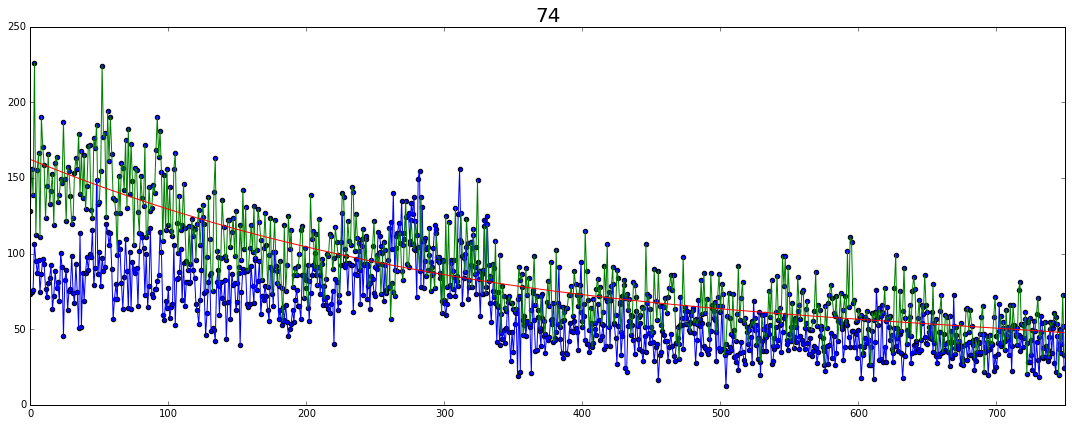

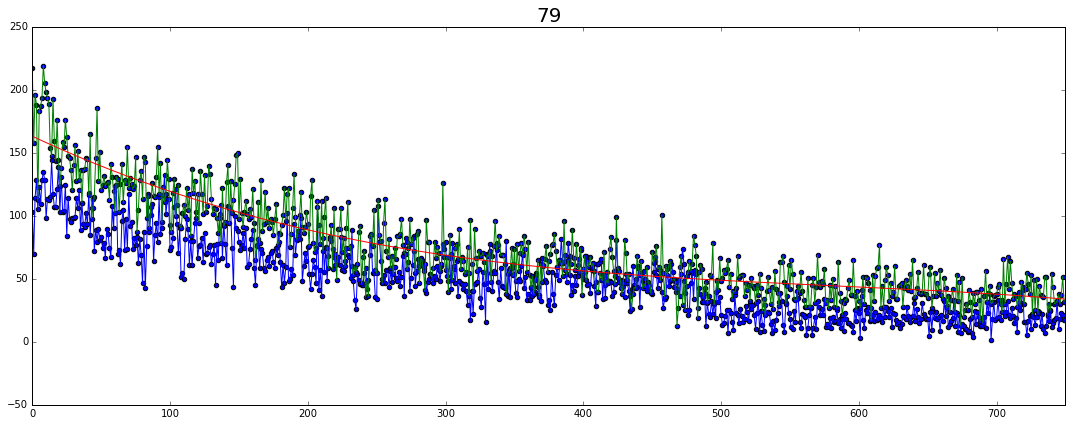

In [318]:

sign = SignalF
backs = BackGF
vals =np.arange(0,len(sign[0]))
Q=0
Offset=4
for x in range(0,len(sign)):
    if meanDif[x]>70 and chiDiff[x]<-0.75:
    #if True :
        plt.figure(figsize=(15,6))
        plt.title(x,fontsize=20)
        
        coefs = poly.polyfit(vals,backs[x], 3)
        ffit  = poly.polyval(vals, coefs)
        #Sig = np.array(aa-ffit*(25/56))
        #bac = np.array(aaB-ffit)
        
        plt.plot(vals,sign[x])
        plt.scatter(vals,sign[x])
        
        plt.plot(vals,backs[x])
        plt.scatter(vals,backs[x])
        plt.plot(vals,ffit,color='r')

        plt.xlim(0,750)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()

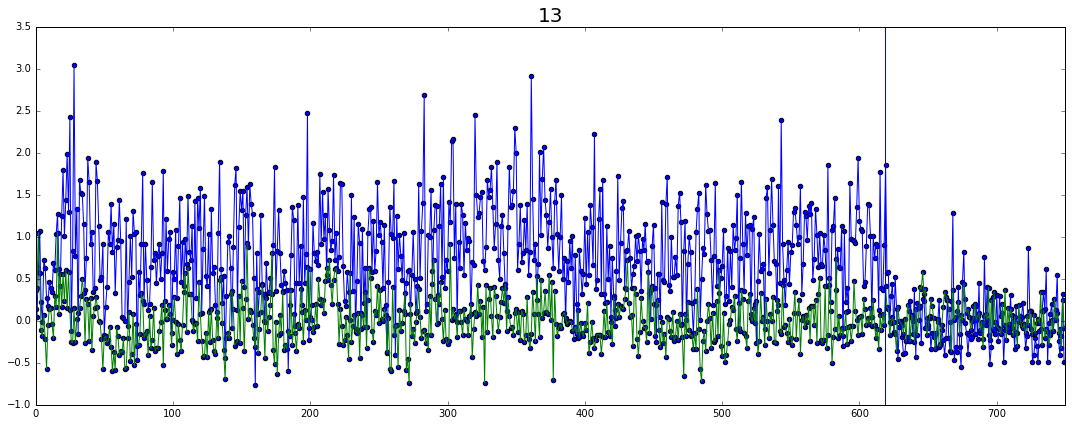

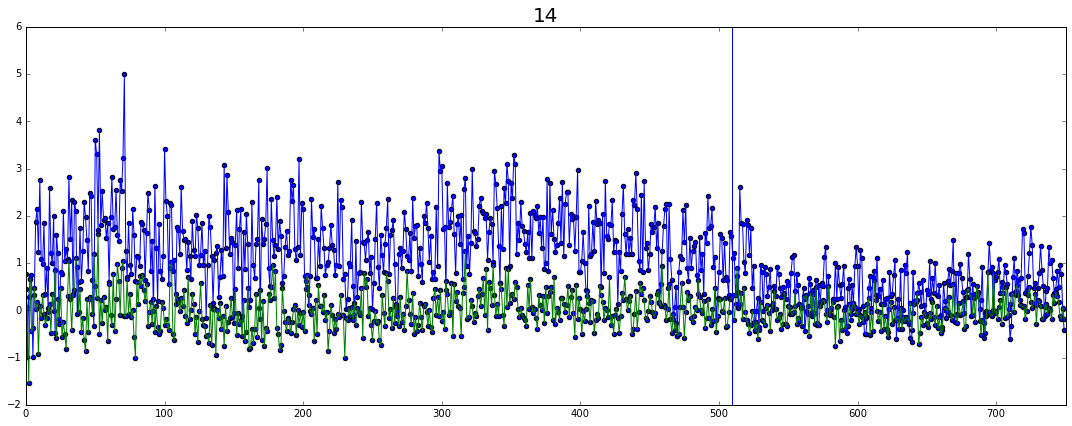

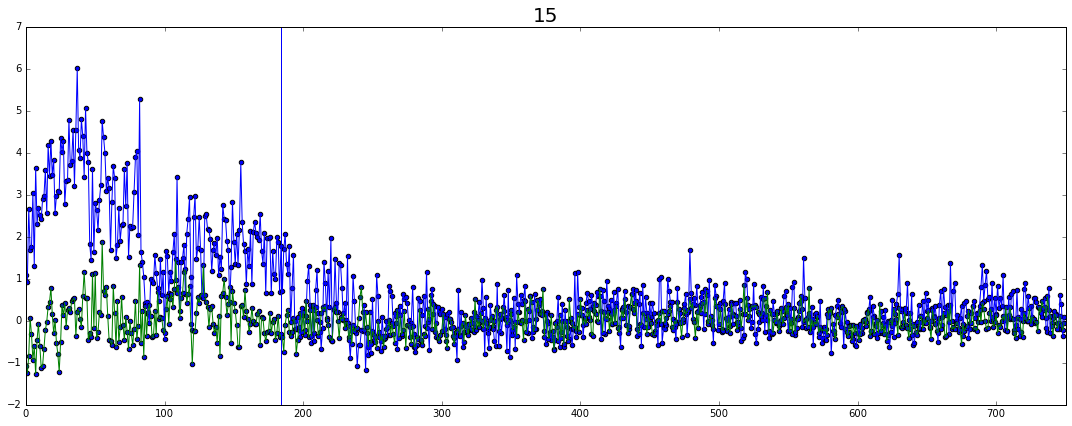

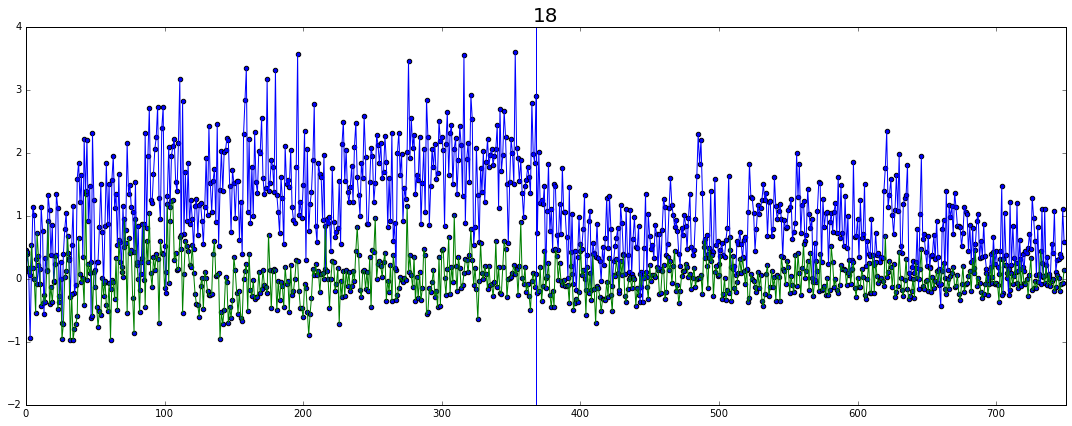

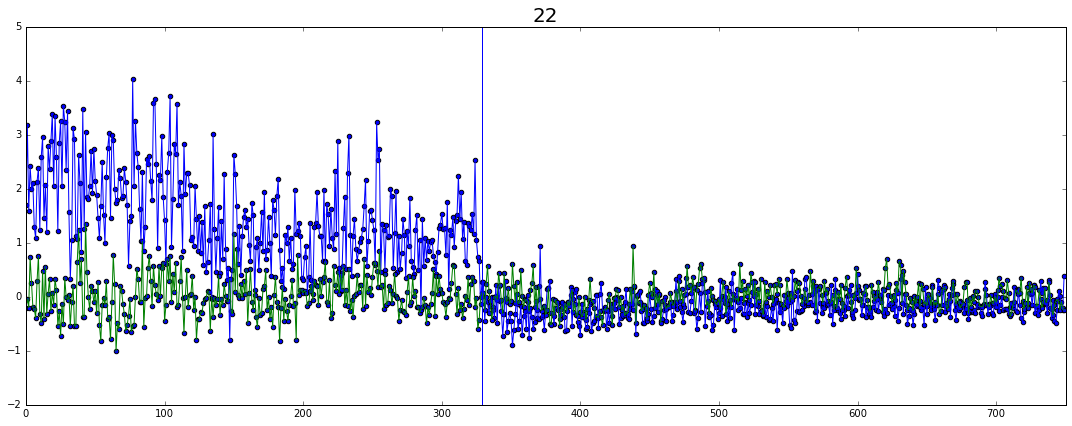

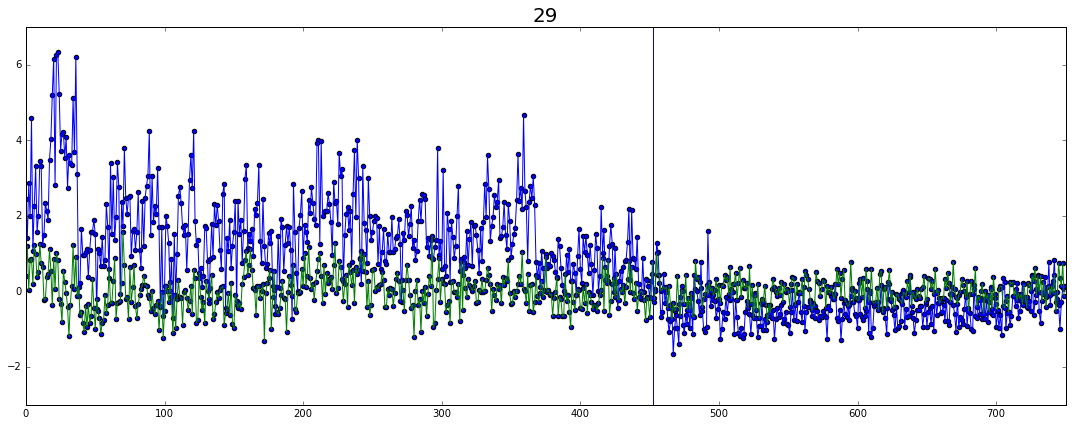

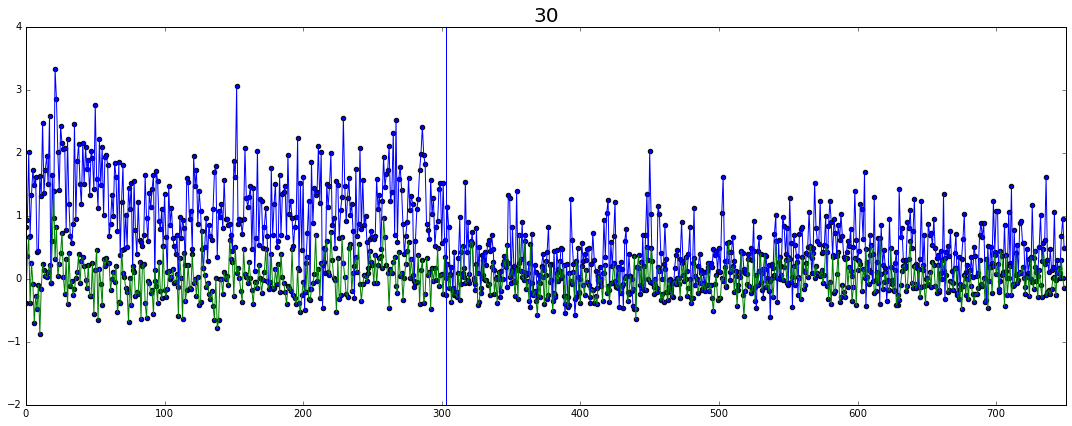

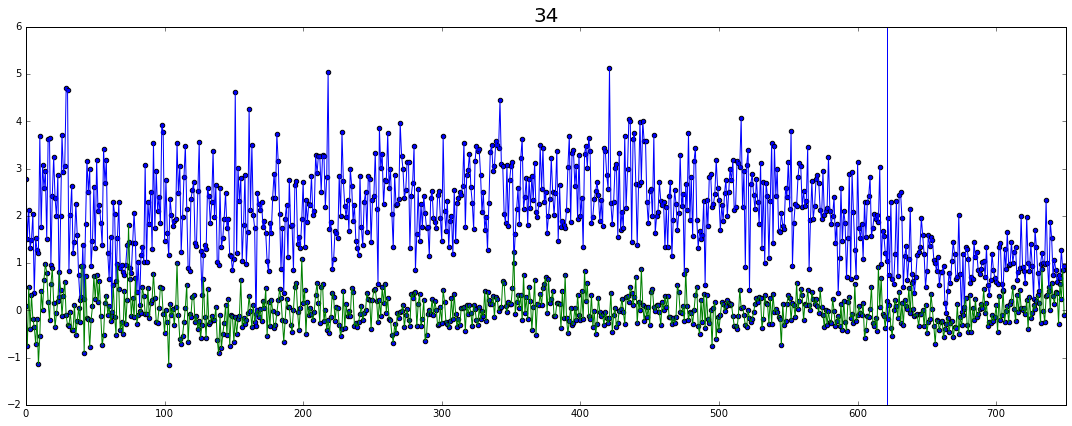

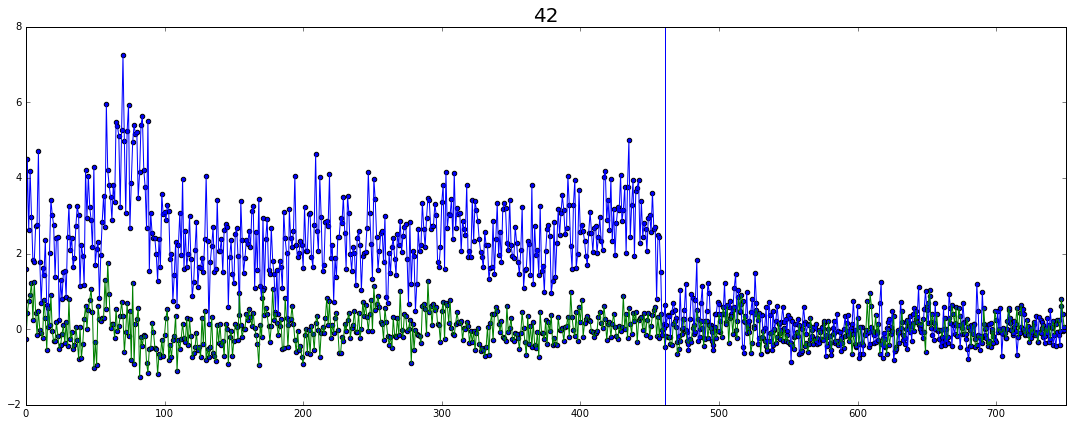

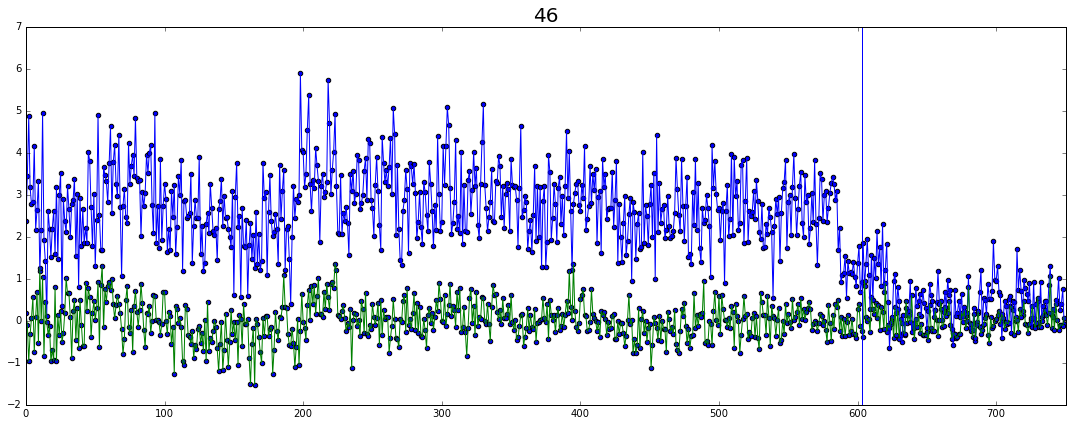

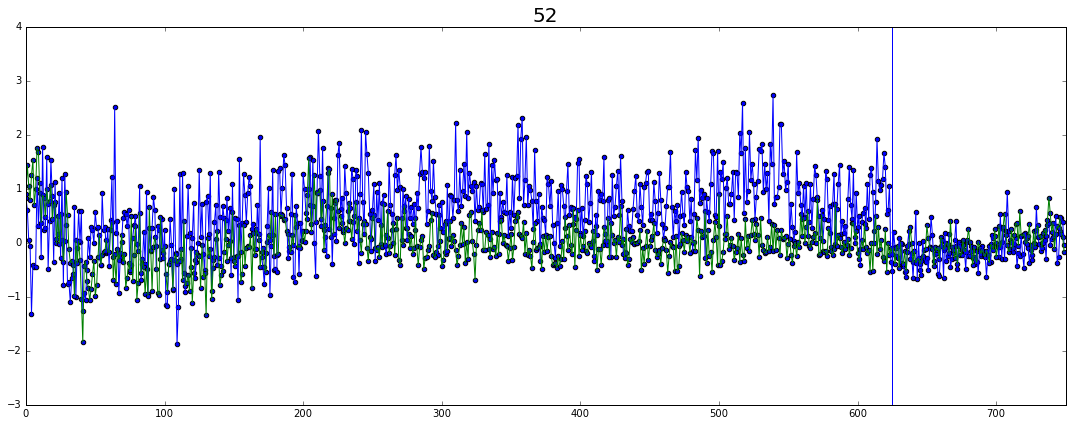

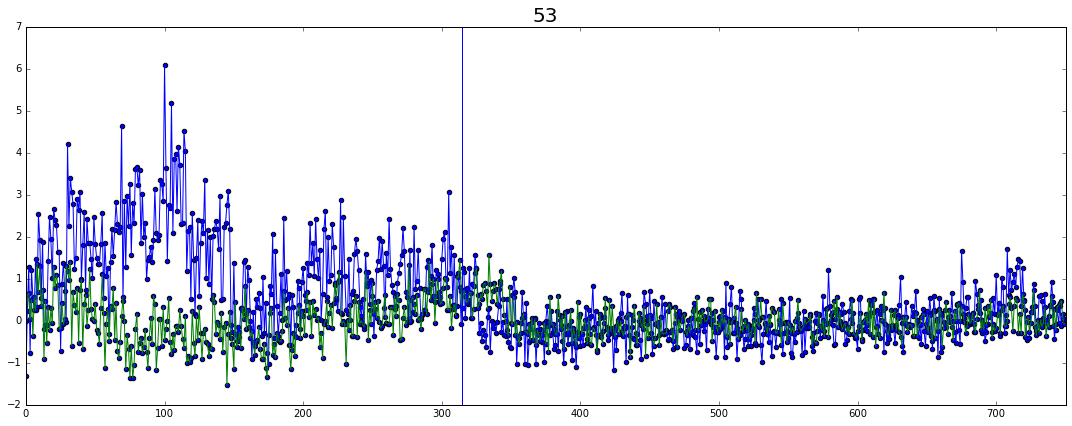

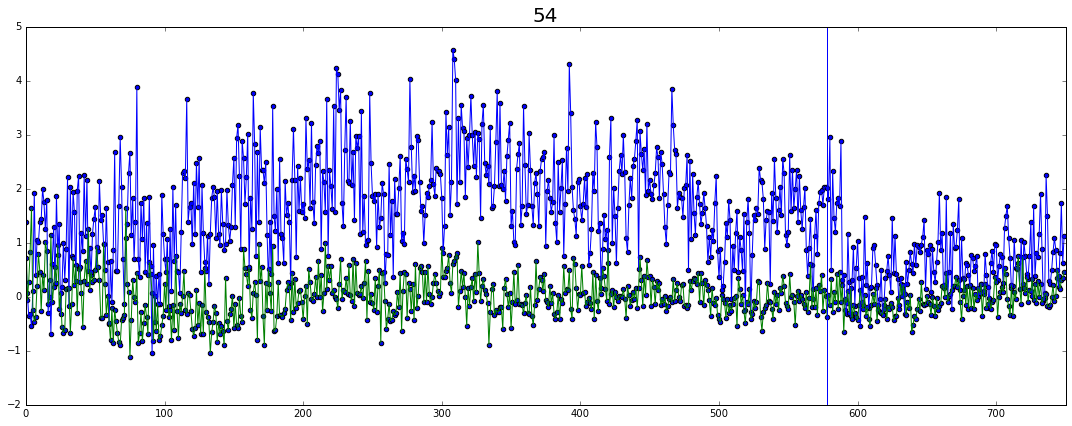

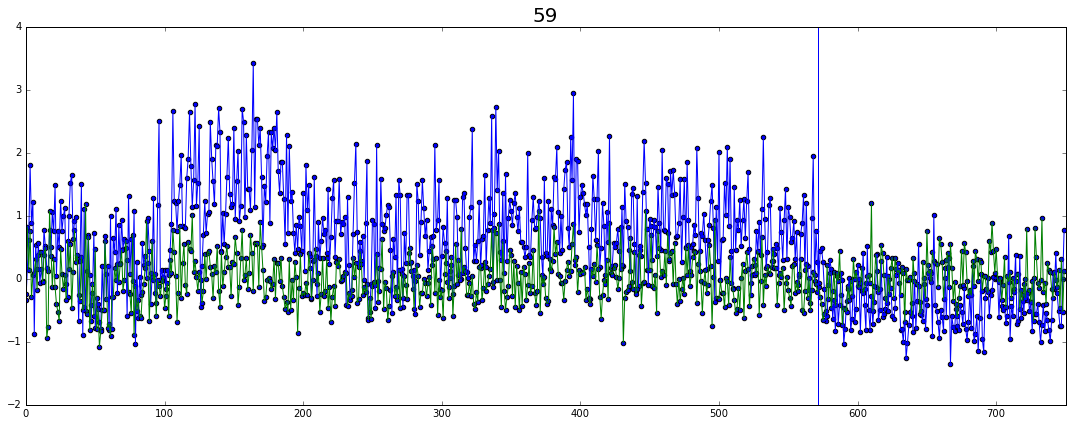

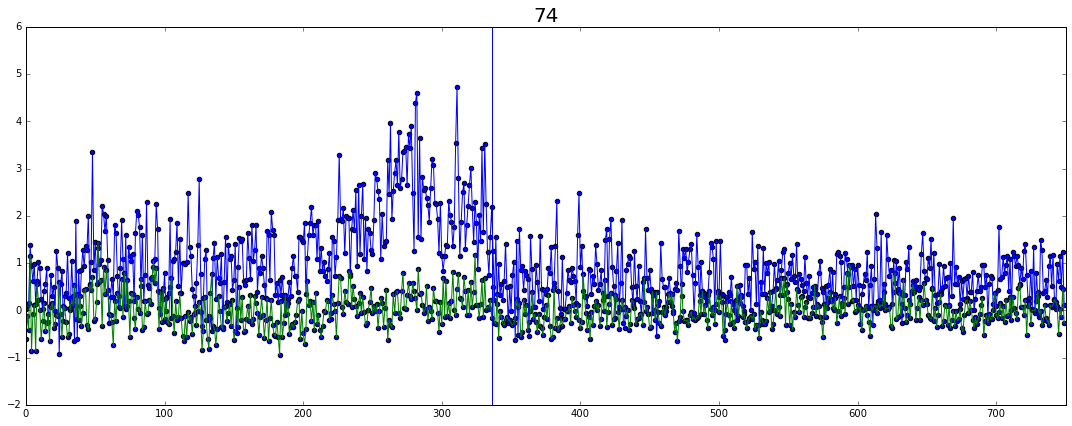

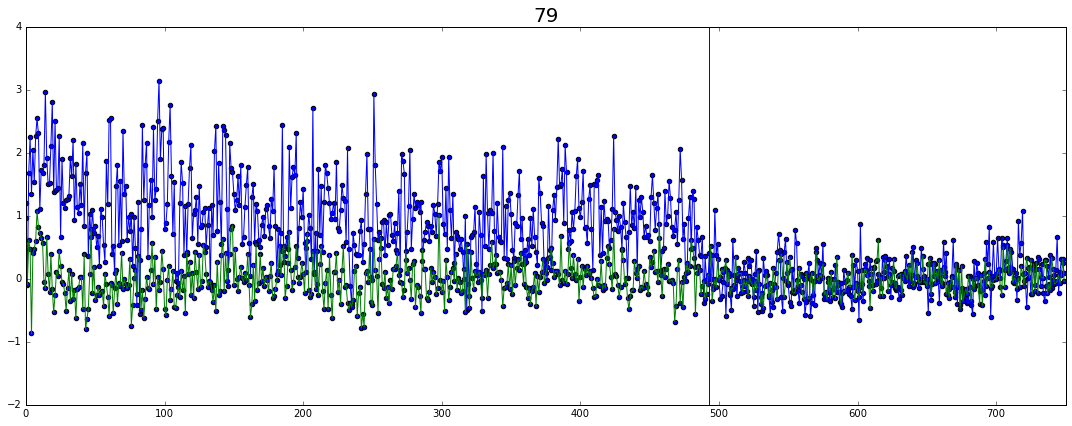

In [319]:

sign = SignalF
backs = BackGF
vals =np.arange(0,len(sign[0]))
Q=0
Offset=4
for x in range(0,len(sign)):
    if meanDif[x]>70 and chiDiff[x]<-0.75:
    #if True :
        plt.figure(figsize=(15,6))
        plt.title(x,fontsize=20)
        
        coefs = poly.polyfit(vals,backs[x], 3)
        ffit  = poly.polyval(vals, coefs)
        #Sig = np.array(aa-ffit*(25/56))
        #bac = np.array(aaB-ffit)
        
        plt.plot(vals,(sign[x]-ffit*(25/56))/25)
        plt.scatter(vals,(sign[x]-ffit*(25/56))/25)
        
        plt.plot(vals,(backs[x]-ffit)/56)
        plt.scatter(vals,(backs[x]-ffit)/56)
        plt.axvline(Tau3[x]*5)
        plt.xlim(0,750)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()

In [12]:
eCoeff = 0.01160
eOffset= 1917
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))

STACK = np.zeros(Shape**2).reshape((Shape,Shape))
A=0
for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM)
    A+=1
    if A==5:
        STACK += Images
        A=0
ImageFit = []
for y in range(0,Shape):
    coefs = poly.polyfit(xvs,STACK[y], 2) # fits 2nd order poly 
    ffit  = poly.polyval(xvs, coefs)
    ImageFit.append(ffit)
STACK = STACK-np.array(ImageFit)
STACK[STACK<0] = 0

In [13]:
XcPass=[]
YcPass=[]
for x in range(0,len(meanDif)):
    if meanDif[x]>70 and chiDiff[x]<-0.75:
        XcPass.append(Xc[x])
        YcPass.append(Yc[x])

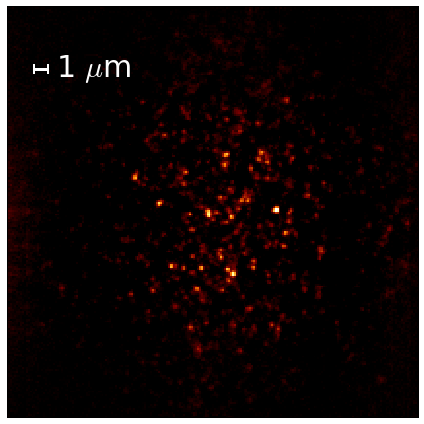

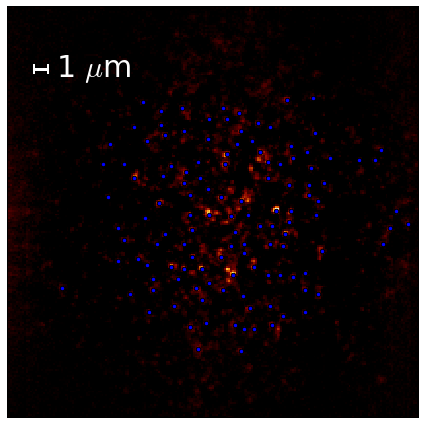

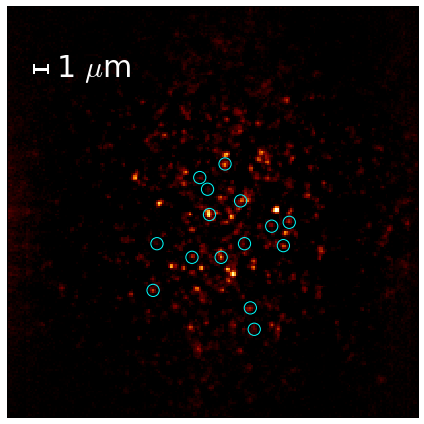

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(STACK, cmap='afmhot', interpolation='none')
plt.xlim(0,211)
plt.ylim(0,211)
plt.plot([14,14+6.25],[179,179],linewidth=3,color='white')
plt.plot([14,14],[177,181],linewidth=2,color='white')
plt.plot([14+6.9,14+6.9],[177,181],linewidth=2,color='white')
plt.text(25,175,r'1 $\mu$m',rotation=0,fontsize=30,color='white')
plt.tick_params(labelbottom='off',labelleft='off')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleBaPlots/2d-2spot5-Ba')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(STACK, cmap='afmhot', interpolation='none')
plt.scatter(Xc,Yc)
plt.xlim(0,211)
plt.ylim(0,211)
plt.plot([14,14+6.25],[179,179],linewidth=3,color='white')
plt.plot([14,14],[177,181],linewidth=2,color='white')
plt.plot([14+6.9,14+6.9],[177,181],linewidth=2,color='white')
plt.text(25,175,r'1 $\mu$m',rotation=0,fontsize=30,color='white')
plt.tick_params(labelbottom='off',labelleft='off')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleBaPlots/2d-2spot5-Ba')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(STACK, cmap='afmhot', interpolation='none')
plt.scatter(XcPass,YcPass,s=150, facecolors='none', edgecolors='aqua')
plt.xlim(0,211)
plt.ylim(0,211)
plt.plot([14,14+6.25],[179,179],linewidth=3,color='white')
plt.plot([14,14],[177,181],linewidth=2,color='white')
plt.plot([14+6.9,14+6.9],[177,181],linewidth=2,color='white')
plt.text(25,175,r'1 $\mu$m',rotation=0,fontsize=30,color='white')
plt.tick_params(labelbottom='off',labelleft='off')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleBaPlots/2d-2spot5-Ba')
plt.show()

In [15]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [16]:
eCoeff = 0.01160
eOffset= 1917
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
STACK = np.zeros(Shape**2).reshape((Shape,Shape))

STACK2 = np.zeros(Shape**2).reshape((Shape,Shape))
A=0
for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM)
    STACK2 += Images
    A+=1
    if A==5:
        STACK += Images
        A=0
ImageFit = []
for y in range(0,Shape):
    coefs = poly.polyfit(xvs,STACK[y], 2) # fits 2nd order poly 
    ffit  = poly.polyval(xvs, coefs)
    ImageFit.append(ffit)
STACK = STACK-np.array(ImageFit)
STACK[STACK<0] = 0

In [17]:
made=[]
Xmade=[]
Ymade=[]
Hmade=[]

yposI, xposI  = np.indices((9,9)) 
X = xposI.flatten()   
Y = yposI.flatten()
A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
xtest=np.array([0,1,2,3,4,5,6,7,8])

eCoeff = 0.01160
eOffset= 1917
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
STACK3 = np.zeros(Shape**2).reshape((Shape,Shape))
Row = int(4)
Col = int(4)
#A=-1
#for q in range(0,TauH):#len(files)):
for q in range(0,len(files)):
#for q in range(0,1):#len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM)
    STACK3 += Images
for x in range(0,len(meanDif)):
    TauH   = int(Tau3[x])
    if meanDif[x]>70 and chiDiff[x]<-0.75:
        #A+=1
        Xindex = int(Xc[x])
        Yindex = int(Yc[x])
        testspot = STACK3[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
        testspot = np.array(testspot)
        testspot1 = np.array(testspot)

        spot = testspot[2:7,2:7]
        #SpotRemove = np.zeros(25).reshape((5,5))

        SpotRemove = np.random.uniform(0.95,1.1,25).reshape((5,5))
        SpotRemove = SpotRemove*testspot.mean()
        testspot1[2:7,2:7]=SpotRemove
        spotB = testspot1
        
        B = spotB.flatten()#Z.flatten()
        coeff, r, rank, s = np.linalg.lstsq(A, B)
        PlaneFit=[]
        for q in range( 0,len(xtest)):
            qw = PolyPlane(*coeff,xtest,xtest[q])
            PlaneFit.append(qw)
        PlaneFit=np.array(PlaneFit)
        PlaneFit
        
        #testspot = testspot-testspot.min()
        #testspot[testspot < 0] = 0 
        #testspot = np.nan_to_num(testspot)
        SPOT= (testspot-PlaneFit)[2:7,2:7]
        made.append(SPOT)
        
        
        
        params = fitgaussian(SPOT)
        fit = gaussian(*params)
        
        Xmade.append(Xindex+params[1]-2)
        Ymade.append(Yindex+params[2]-2)
        Hmade.append(testspot.sum())
        
        plt.imshow(SPOT, interpolation='nearest')
        plt.contour(fit(*np.indices(SPOT.shape)))
        plt.scatter(params[1],params[2],color='m')
        plt.xlim(-0.5,4.5)
        plt.ylim(-0.5,4.5)
        sigmaT = np.sqrt((params[3]*160)**2+(params[4]*160)**2)
        RES = (sigmaT)/np.sqrt(SPOT.sum())
        print('sigmaT =', sigmaT)
        print('super res =', RES)
        print('area = ', SPOT.sum())
        print('index = ', x)
        plt.show()

NameError: name 'PolyPlane' is not defined

In [21]:
final = np.zeros(Shape**2).reshape((Shape,Shape))

for x in range(0,len(XcPass)):
    final[int(YcPass[x]),int(XcPass[x])] = Hmade[x]

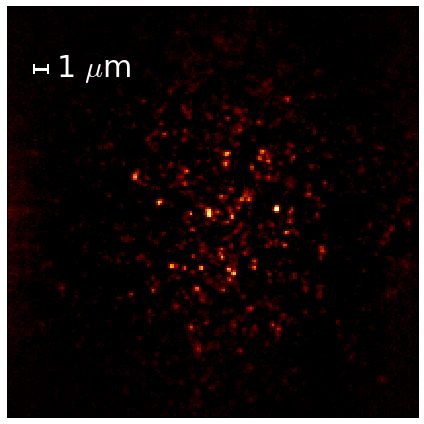

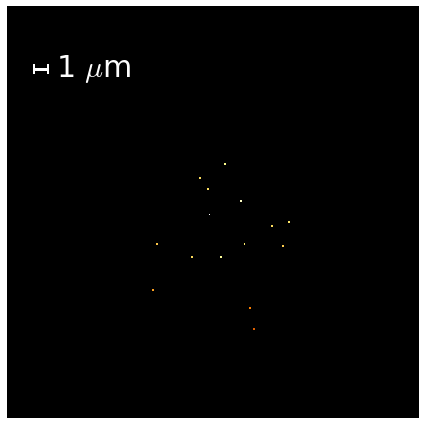

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(STACK, cmap='afmhot', interpolation='nearest')
#plt.scatter(XcPass,YcPass,s=150, facecolors='none', edgecolors='aqua')
plt.xlim(0,211)
plt.ylim(0,211)
plt.plot([14,14+6.25],[179,179],linewidth=3,color='white')
plt.plot([14,14],[177,181],linewidth=2,color='white')
plt.plot([14+6.9,14+6.9],[177,181],linewidth=2,color='white')
plt.text(25,175,r'1 $\mu$m',rotation=0,fontsize=30,color='white')
plt.tick_params(labelbottom='off',labelleft='off')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleBaPlots/superres-no')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(final, cmap='afmhot', interpolation='none')
#plt.scatter(XcPass,YcPass,s=150, facecolors='none', edgecolors='aqua')
plt.xlim(0,211)
plt.ylim(0,211)
plt.plot([14,14+6.25],[179,179],linewidth=3,color='white')
plt.plot([14,14],[177,181],linewidth=2,color='white')
plt.plot([14+6.9,14+6.9],[177,181],linewidth=2,color='white')
plt.text(25,175,r'1 $\mu$m',rotation=0,fontsize=30,color='white')
plt.tick_params(labelbottom='off',labelleft='off')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleBaPlots/superres-yes')
plt.show()

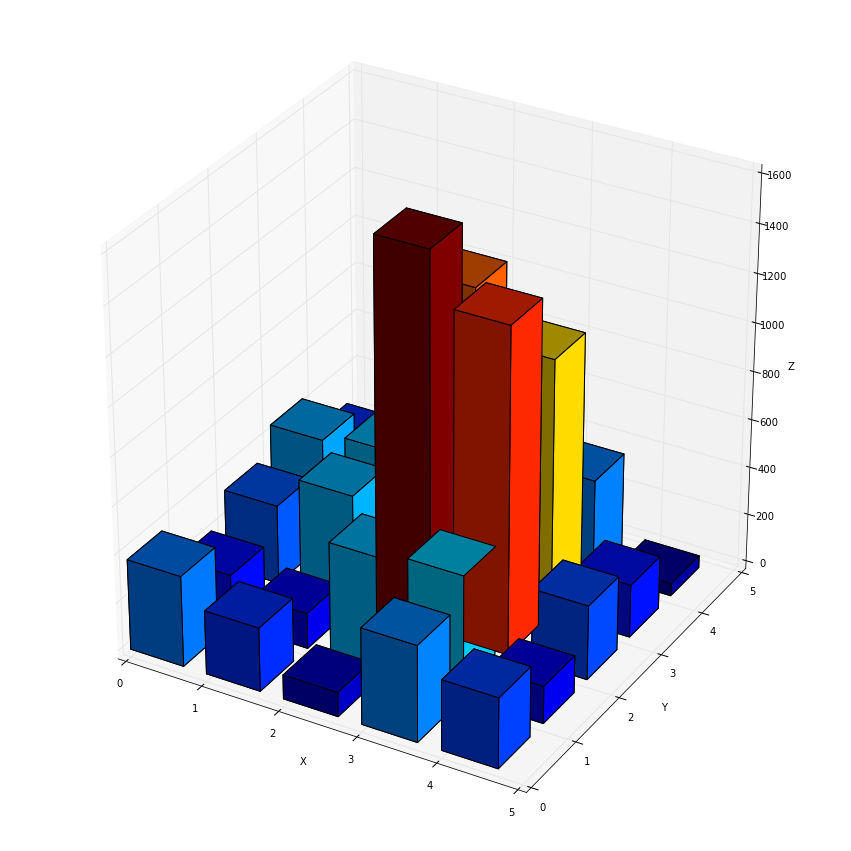

In [339]:
from mpl_toolkits.mplot3d import Axes3D

data = abs(made[0])


ypos, xpos  = np.indices(data.shape) 
xpos = xpos.flatten()   
ypos = ypos.flatten()
zpos = np.zeros(xpos.shape)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(data.flatten()/float(data.max()))
ax.bar3d(xpos,ypos,zpos, .7,.7,data.flatten(), color=colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_zlim(2500, 4500)
#plt.savefig('/Users/austinmcdonald/Desktop/CCD/CCD-image.pdf')

plt.show()

sigmaT = 239.939567725
super res = 3.04605379426
area =  6204.81170257
index =  3


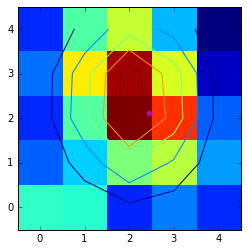

sigmaT = 247.29357067
super res = 2.6082727704
area =  8989.17087046
index =  11


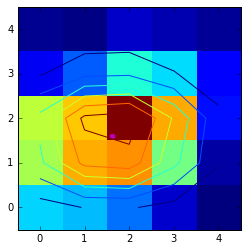

sigmaT = 187.027148604
super res = 2.08763432441
area =  8026.02388399
index =  18


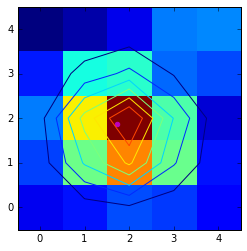

sigmaT = 166.423478583
super res = 2.21002306165
area =  5670.68573404
index =  38


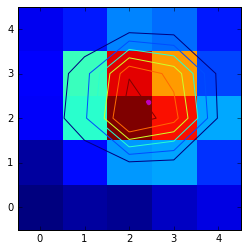

sigmaT = 201.966891901
super res = 2.19503586822
area =  8465.97772897
index =  39


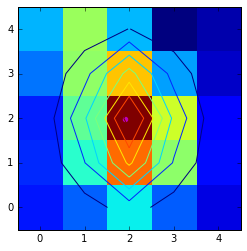

sigmaT = 218.036051103
super res = 2.13202380477
area =  10458.57504
index =  43


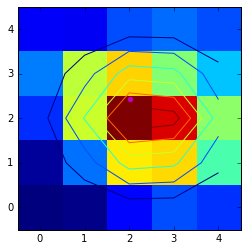

sigmaT = 164.529633782
super res = 2.89827404441
area =  3222.62199606
index =  44


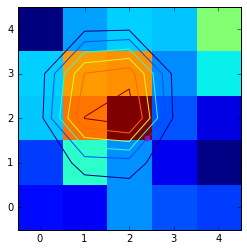

sigmaT = 216.360167503
super res = 2.71754887427
area =  6338.69552215
index =  46


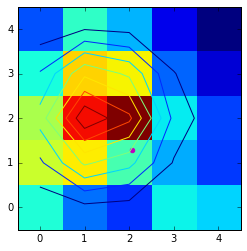

sigmaT = 887.095017451
super res = 14.9179748692
area =  3536.06742528
index =  57


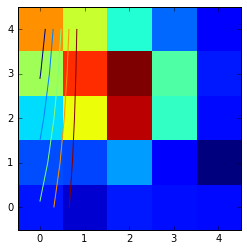

sigmaT = 196.19723469
super res = 2.40370484155
area =  6662.28930011
index =  59


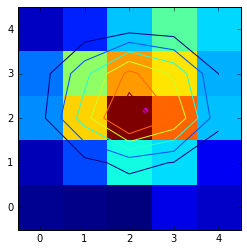

sigmaT = 281.746918967
super res = 1.80974987832
area =  24237.1326004
index =  63


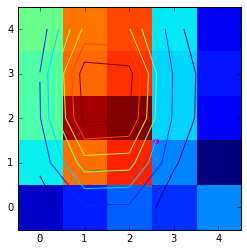

sigmaT = 169.129419925
super res = 2.2364338176
area =  5719.08060143
index =  70


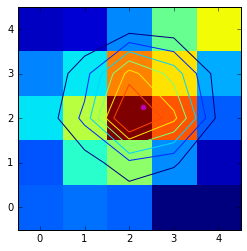

sigmaT = 530.74478328
super res = 13.8395561558
area =  1470.71033352
index =  76


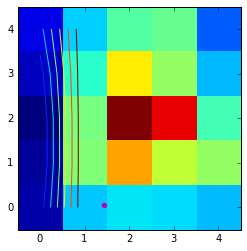

sigmaT = 177.051145703
super res = 3.03255416404
area =  3408.63382951
index =  82


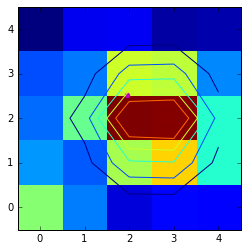

sigmaT = 222.994328959
super res = 1.85024021108
area =  14525.510566
index =  90


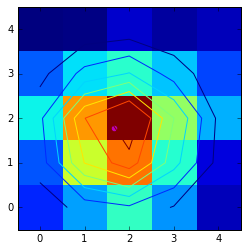

In [19]:
made=[]
Xmade=[]
Ymade=[]
Hmade=[]

yposI, xposI  = np.indices((9,9)) 
X = xposI.flatten()   
Y = yposI.flatten()
A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
xtest=np.array([0,1,2,3,4,5,6,7,8])

eCoeff = 0.01160
eOffset= 1917
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
STACK3 = np.zeros(Shape**2).reshape((Shape,Shape))
Row = int(4)
Col = int(4)
#A=-1
#for q in range(0,TauH):#len(files)):
for q in range(0,len(files)):
#for q in range(0,1):#len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM)
    STACK3 += Images
for x in range(0,len(meanDif)):
    TauH   = int(Tau3[x])
    if meanDif[x]>70 and chiDiff[x]<-0.75:
        #A+=1
        Xindex = int(Xc[x])
        Yindex = int(Yc[x])
        testspot = STACK3[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
        testspot = np.array(testspot)
        testspot1 = np.array(testspot)

        spot = testspot[2:7,2:7]
        #SpotRemove = np.zeros(25).reshape((5,5))

        SpotRemove = np.random.uniform(0.95,1.1,25).reshape((5,5))
        SpotRemove = SpotRemove*testspot.mean()
        testspot1[2:7,2:7]=SpotRemove
        spotB = testspot1
        
        B = spotB.flatten()#Z.flatten()
        coeff, r, rank, s = np.linalg.lstsq(A, B)
        PlaneFit=[]
        for q in range( 0,len(xtest)):
            qw = PolyPlane(*coeff,xtest,xtest[q])
            PlaneFit.append(qw)
        PlaneFit=np.array(PlaneFit)
        PlaneFit
        
        #testspot = testspot-testspot.min()
        #testspot[testspot < 0] = 0 
        #testspot = np.nan_to_num(testspot)
        SPOT= (testspot-PlaneFit)[2:7,2:7]
        made.append(SPOT)
        
        
        
        params = fitgaussian(SPOT)
        fit = gaussian(*params)
        
        Xmade.append(Xindex+params[1]-2)
        Ymade.append(Yindex+params[2]-2)
        Hmade.append(testspot.sum())
        
        plt.imshow(SPOT, interpolation='nearest')
        plt.contour(fit(*np.indices(SPOT.shape)))
        plt.scatter(params[1],params[2],color='m')
        plt.xlim(-0.5,4.5)
        plt.ylim(-0.5,4.5)
        sigmaT = np.sqrt((params[3]*160)**2+(params[4]*160)**2)
        RES = (sigmaT)/np.sqrt(SPOT.sum())
        print('sigmaT =', sigmaT)
        print('super res =', RES)
        print('area = ', SPOT.sum())
        print('index = ', x)
        plt.show()

In [309]:
len(made)

16

In [310]:
made[13].sum()

4994.860597855235

In [ ]:
len

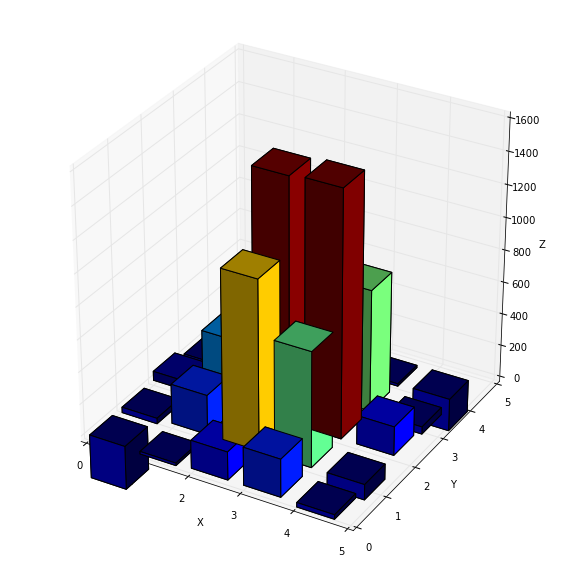

In [322]:
from mpl_toolkits.mplot3d import Axes3D

data = made[4] #testspot-PlaneFit#-3000

ypos, xpos  = np.indices(data.shape) 
xpos = xpos.flatten()   
ypos = ypos.flatten()
zpos = np.zeros(xpos.shape)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(data.flatten()/float(data.max()))
ax.bar3d(xpos,ypos,zpos, .7,.7,data.flatten(), color=colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_zlim(0, 1500)
#plt.savefig('/Users/austinmcdonald/Desktop/CCD/CCD-image.pdf')

plt.show()

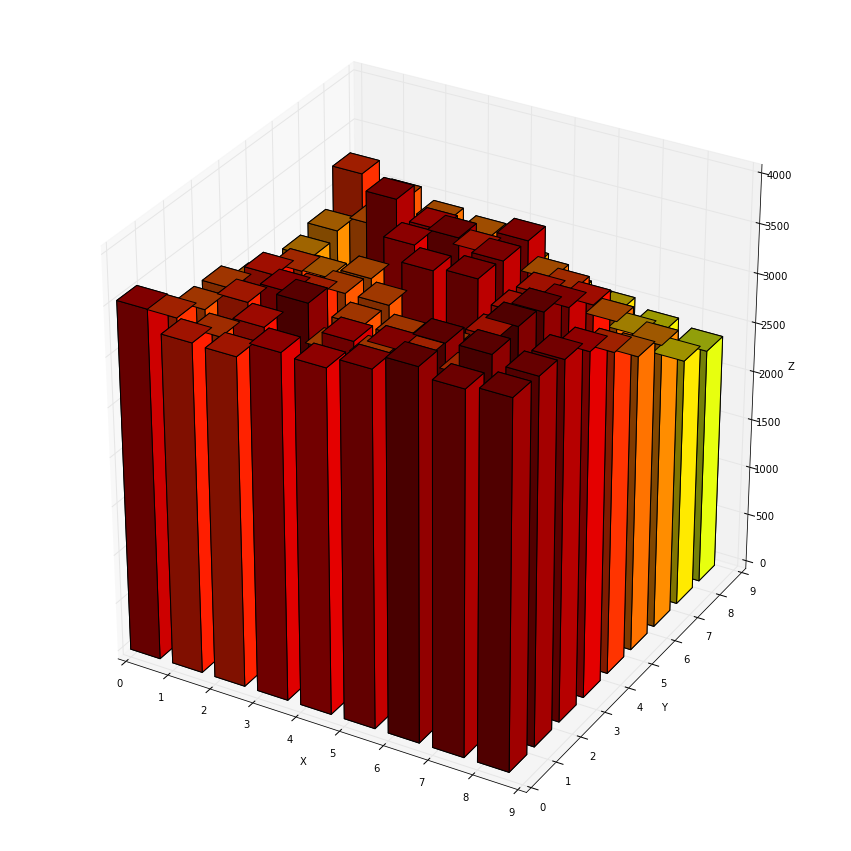

In [220]:
from mpl_toolkits.mplot3d import Axes3D

data = spotB#made[5]#-3000

ypos, xpos  = np.indices(data.shape) 
xpos = xpos.flatten()   
ypos = ypos.flatten()
zpos = np.zeros(xpos.shape)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(data.flatten()/float(data.max()))
ax.bar3d(xpos,ypos,zpos, .7,.7,data.flatten(), color=colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_zlim(0, 1500)
#plt.savefig('/Users/austinmcdonald/Desktop/CCD/CCD-image.pdf')

plt.show()

solution:
1.214908 x + 1.542987 y + 4.294946 = z
errors:
[[-5.85578373]
 [ 3.93705501]
 [ 0.99999075]
 [-0.4756258 ]
 [ 0.9972138 ]
 [-3.44185466]
 [ 3.23897717]
 [ 0.84699014]
 [-2.31427271]
 [ 2.06731003]]
residual:
9.20302123969


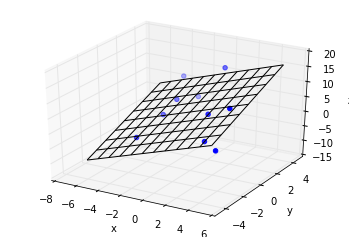

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

N_POINTS = 10
TARGET_X_SLOPE = 2
TARGET_y_SLOPE = 3
TARGET_OFFSET  = 5
EXTENTS = 5
NOISE = 5

# create random data
xs = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
ys = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
zs = []
for i in range(N_POINTS):
    zs.append(xs[i]*TARGET_X_SLOPE + \
              ys[i]*TARGET_y_SLOPE + \
              TARGET_OFFSET + np.random.normal(scale=NOISE))

# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

print( "solution:")
print( "%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
print( "errors:")
print( errors)
print( "residual:")
print( residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

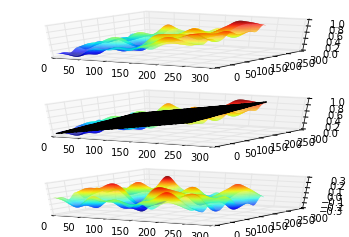

In [113]:
m = 256 #size of the matrix

X1, X2 = np.mgrid[:m, :m]

fig = plt.figure()
ax = fig.add_subplot(3,1,1, projection='3d')
jet = plt.get_cmap('jet')

#generation of the surface
F = 3        
i = np.minimum(X1, m-X1-1)
j = np.minimum(X2, m-X2-1)
H = np.exp(-.5*(np.power(i, 2)  +  np.power(j, 2)   )/(F*F))
Y = np.real(  np.fft.ifft2   (H  *  np.fft.fft2(  np.random.randn(m, m))))
a = 0.0005; b = 0.0002; #parameters of the tilted plane
Y = Y + (a*X1 + b*X2); #adding the plane
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) #data scaling

#plot the initial topological surface
ax.plot_surface(X1,X2,Y, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)


#Regression
X = np.hstack(   ( np.reshape(X1, (m*m, 1)) , np.reshape(X2, (m*m, 1)) ) )
X = np.hstack(   ( np.ones((m*m, 1)) , X ))
YY = np.reshape(Y, (m*m, 1))

theta = np.dot(np.dot( np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)

plane = np.reshape(np.dot(X, theta), (m, m));

ax = fig.add_subplot(3,1,2, projection='3d')
ax.plot_surface(X1,X2,plane)
ax.plot_surface(X1,X2,Y, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)


#Subtraction
Y_sub = Y - plane
ax = fig.add_subplot(3,1,3, projection='3d')
ax.plot_surface(X1,X2,Y_sub, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)

plt.show()

In [115]:
X2

array([[  0,   1,   2, ..., 253, 254, 255],
       [  0,   1,   2, ..., 253, 254, 255],
       [  0,   1,   2, ..., 253, 254, 255],
       ..., 
       [  0,   1,   2, ..., 253, 254, 255],
       [  0,   1,   2, ..., 253, 254, 255],
       [  0,   1,   2, ..., 253, 254, 255]])

In [121]:

x = np.linspace(1, 9, 9)
y = np.linspace(1, 9, 9)
X, Y = np.meshgrid(x, y, copy=False)
Z = X**2 + Y**2 + np.random.rand(*X.shape)*0.01

X = X.flatten()
Y = Y.flatten()

A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
B = Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B)

In [122]:
x

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [117]:
coeff

array([  3.99450990e-03,   7.26466154e-04,   7.35853008e-03,
         1.00064941e+00,   2.60623420e-02,  -3.68767489e-02,
         9.93614342e-01,   3.46982334e-02,  -2.77891512e-02])

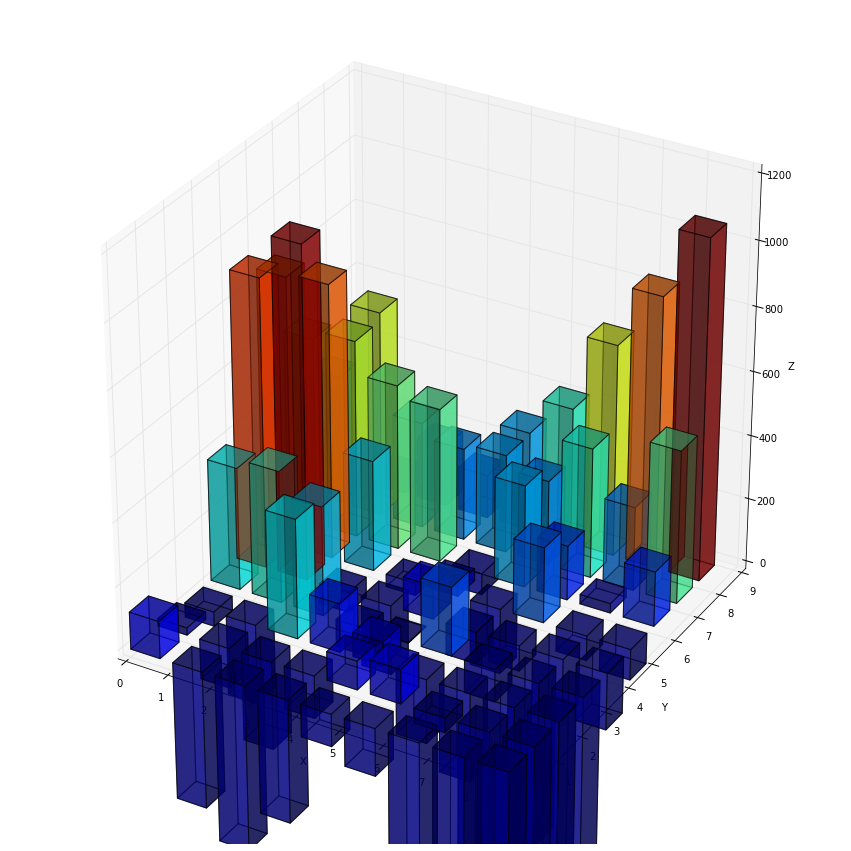

In [268]:
from mpl_toolkits.mplot3d import Axes3D

data = spotB-PlaneFit #made[5]#-3000

yposI, xposI  = np.indices(data.shape) 
xpos = xposI.flatten()   
ypos = yposI.flatten()
zpos = np.zeros(xpos.shape)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(data.flatten()/float(data.max()))
ax.bar3d(xpos,ypos,zpos, .7,.7,data.flatten(), color=colors,alpha=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.plot_surface(xposI,yposI,data)
#ax.plot_surface(xposI,yposI,PlaneFit,color='r')
#ax.set_zlim(0, 1500)
#plt.savefig('/Users/austinmcdonald/Desktop/CCD/CCD-image.pdf')

plt.show()

In [274]:
x = xpos
y = ypos
#X, Y = np.meshgrid(x, y, copy=False)
#Z = X**2 + Y**2 + np.random.rand(*X.shape)*0.01

X = xpos#X.flatten()
Y = ypos#Y.flatten()

A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
B = data.flatten()#Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B)


In [239]:
coeff

array([  3.52075339e+03,  -8.72441332e+01,  -2.61429884e+02,
         1.51623548e+01,  -1.33952864e+01,   1.23686744e+00,
         2.55885229e+01,  -1.53648233e+01,   1.34413837e+02])

In [202]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])

In [191]:
data

array([[ 3541.0972,  3336.4848,  3326.2304,  3491.6   ,  3469.27  ,
         3583.4372,  3732.2188,  3646.228 ,  3692.8252],
       [ 3244.2764,  3180.5808,  3398.3708,  3752.8784,  3508.0952,
         3548.6836,  3738.506 ,  3755.6276,  3675.1584],
       [ 3115.4004,  3308.5868,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  3806.54  ,  3616.88  ],
       [ 3113.3124,  3368.176 ,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  3732.6132,  3475.7196],
       [ 2936.9924,  3200.9272,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  3565.5732,  3252.4428],
       [ 2773.386 ,  2929.6496,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  3380.414 ,  2994.8068],
       [ 2814.2064,  2536.3516,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  3005.1308,  2892.3556],
       [ 2878.2616,  3044.478 ,  2796.47  ,  2973.254 ,  3041.288 ,
         2979.9124,  2829.936 ,  2653.964 ,  2518.9748],


In [18]:
def PolyPlane(a,b,c,d,e,f,g,h,i,x,y):
    return a+b*x+c*y+d*x**2+e*x**2*y+f*x**2*y**2+g*y**2+h*x*y**2+i*x*y
#def PolyPlane(a,b,c,x,y):
#    return a+b*x+c*y

In [253]:
xtest=np.array([0,1,2,3,4,5,6,7,8])

In [255]:
PlaneFit=[]
for q in range( 0,len(xtest)):
    qw = PolyPlane(*coeff,xtest,xtest[q])
    PlaneFit.append(qw)
PlaneFit=np.array(PlaneFit)
PlaneFit

array([[ 3520.75339367,  3448.67161535,  3406.9145467 ,  3395.48218773,
         3414.37453842,  3463.59159879,  3543.13336882,  3652.99984852,
         3793.1910379 ],
       [ 3284.91203255,  3319.72084908,  3360.53753735,  3407.36209734,
         3460.19452906,  3519.03483251,  3583.88300768,  3654.73905459,
         3731.60297322],
       [ 3100.24771728,  3213.69121689,  3313.77322004,  3400.49372674,
         3473.85273699,  3533.85025077,  3580.48626811,  3613.76078899,
         3633.67381342],
       [ 2966.76044786,  3130.58271877,  3266.62159479,  3374.87707594,
         3455.34916221,  3508.03785359,  3532.9431501 ,  3530.06505173,
         3499.40355848],
       [ 2884.4502243 ,  3070.39535472,  3219.0826616 ,  3330.51214493,
         3404.68380472,  3441.59764096,  3441.25365366,  3403.65184281,
         3328.79220842],
       [ 2853.31704659,  3033.12912475,  3171.15642046,  3267.39893371,
         3321.85666452,  3334.52961288,  3305.41777878,  3234.52116223,
         31

In [206]:
len(PlaneFit)

81

In [189]:
ad = np.array([1,2,3,4])
add = np.array([11,21,31,41])

In [178]:
AA=[1,1,1,1,1,1,1,1,1]

In [136]:
coeff

array([ 3412.21852806,   258.31029983,    69.56677683,   -27.64508104,
         141.10429196,   -17.94693161,   -15.31904491,   138.58291814,
       -1105.39145199])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

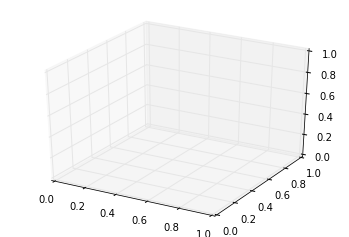

In [320]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
#ax.plot_surface(X1,X2,Y_sub)#, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)
ax.plot_surface(xposI,yposI,data)#, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)
ax.plot_surface(xposI,yposI,PlaneFit)

In [198]:
data[0]

array([ 3541.0972,  3336.4848,  3326.2304,  3491.6   ,  3469.27  ,
        3583.4372,  3732.2188,  3646.228 ,  3692.8252])

In [205]:
PlaneFit[0]

array([ 3412.21852806,  3642.88374684,  3818.25880354,  3938.34369815,
        4003.13843067,  4012.6430011 ,  3966.85740944,  3865.78165569,
        3709.41573986,  3412.21852806,  3642.88374684,  3818.25880354,
        3938.34369815,  4003.13843067,  4012.6430011 ,  3966.85740944,
        3865.78165569,  3709.41573986,  3412.21852806,  3642.88374684,
        3818.25880354,  3938.34369815,  4003.13843067,  4012.6430011 ,
        3966.85740944,  3865.78165569,  3709.41573986,  3412.21852806,
        3642.88374684,  3818.25880354,  3938.34369815,  4003.13843067,
        4012.6430011 ,  3966.85740944,  3865.78165569,  3709.41573986,
        3412.21852806,  3642.88374684,  3818.25880354,  3938.34369815,
        4003.13843067,  4012.6430011 ,  3966.85740944,  3865.78165569,
        3709.41573986,  3412.21852806,  3642.88374684,  3818.25880354,
        3938.34369815,  4003.13843067,  4012.6430011 ,  3966.85740944,
        3865.78165569,  3709.41573986,  3412.21852806,  3642.88374684,
      

In [146]:
ypos, xpos  = np.indices(data.shape)
ypos

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8]])

In [ ]:
        #params = fitgaussian(testspot)
        #fit = gaussian(*params)
        
        #Xmade.append(Xindex+params[1]-2)
        #Ymade.append(Yindex+params[2]-2)
        #Hmade.append(testspot.sum())
        
        #plt.imshow(testspot, interpolation='nearest')
        #plt.contour(fit(*np.indices(testspot.shape)))
        #plt.scatter(params[1],params[2],color='m')
        #plt.xlim(-0.5,4.5)
        #plt.ylim(-0.5,4.5)
        #sigmaT = params[3]*160#np.sqrt((params[3]*160)**2+(params[4]*160)**2)
        #RES = (sigmaT)/np.sqrt(testspot.sum())
        #print('sigmaT =', sigmaT)
        #print('super res =', RES)
        #print('area = ', testspot.sum())
        #print('index = ', A)
        #plt.show()